# Chignolin

In [104]:
import pyemma
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
import multiprocessing
from collections import Counter
import copy
import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')
from pathlib import Path
from typing import *
from dataclasses import dataclass 


# NMM modules
import sys
sys.path.append('/home/rob/Research/NMpathAnalysis/nmpath')
from nmm import NonMarkovModel, MarkovPlusColorModel, DiscretePathEnsemble

## Auxiliary functions

In [125]:
@dataclass
class TPSStats:
    transition_paths: List[np.ndarray] # a list of transition paths
    prop_direct: List[float] # proportion of transition paths that are direct
    mean_length: List[float] # mean length of transition paths that are indirect
    state_prop: List[np.ndarray] # proportion of each indirect state on a transition path
    

In [195]:
def get_tps(trajs, ini_state, final_state, n_states, misfolded_state=[]):
    
    macro_dict = dict()
    for micro in ini_state:
        macro_dict[micro] = 0
    for micro in final_state:
        macro_dict[micro] = 2
    for micro in [x for x in range(n_states) if x not in ini_state+final_state]:
        macro_dict[micro] = 1
    
    tps_list=[]
    for traj in trajs:
        if isinstance(traj, np.ndarray): traj = traj.tolist()
        macro_traj = list(map(macro_dict.get, traj))
        tp=[]
        for i in range(0,len(macro_traj)):
            if macro_traj[i] == 0:
                tp = [traj[i]]
            elif macro_traj[i] == 2 and len(tp)>0:
                tp.append(traj[i])
                tps_list.append(np.array(tp))
                tp=[]
            elif len(tp)>0:
                tp.append(traj[i])
                
    if misfolded_state:
        tps_list_ = []
        for tps in tps_list:
            if not [microst for microst in tps if microst in misfolded_state]:
                tps_list_.append(tps)
        tps_list = tps_list_
                
    return(tps_list)

def _get_tps_stats(tps, stateA, stateB, n_states, misfolded_state=[]):
    
    # keep only intermediate fragments (of indirect paths) for counts
    tps_indir = np.array([path[1:-1] for path in tps if len(path) > 2])

    # pdirect
    pdirect = len([path for path in tps if len(path) == 2]) / len(tps)

    # mean path length (length of direct paths taken to be zero)
    mean_length = np.sum([len(path) for path in tps_indir]) / len(tps)
    if mean_length == 0: mean_length = np.nan

    # counts (indirect only)
    if len(tps_indir) == 0:
        print('There are no indirect TPs!')
        return pdirect, mean_length, np.nan
    tps_indir_concat = np.concatenate(tps_indir)
    counter = Counter(tps_indir_concat)
    counts = [counter[i] for i in [x for x in range(n_states) if x not in stateA+stateB+misfolded_state]]
    counts = np.array(counts) / len(tps_indir_concat)

    return pdirect, mean_length, counts

def get_tps_stats(tps, stateA, stateB, n_states, bootstrap=False, n_samples=1000, misfolded_state=[]):
    
    if len(tps) == 0:
        print('There are no TPs!')
        return np.nan, np.nan, np.nan

    if bootstrap:
        bootstrap_counts = []
        bootstrap_pdirect = []
        bootstrap_mean_length = []
        for bootstrap_ in range(n_samples):
            tps_ = np.random.choice(tps, len(tps))
            
            pdirect, mean_length, counts = _get_tps_stats(tps_, stateA, stateB, n_states, misfolded_state)
            
            bootstrap_pdirect.append(pdirect)
            bootstrap_mean_length.append(mean_length)
            bootstrap_counts.append(counts)

        return bootstrap_pdirect, bootstrap_mean_length, bootstrap_counts
            
    else:
        return _get_tps_stats(tps, stateA, stateB, n_states, misfolded_state)

def get_tps_w_stats(dtrajs: List[np.ndarray], stateA: np.ndarray, stateB: np.ndarray, 
                    n_states: int, bootstrap: bool = False, n_samples: int = 100, 
                    misfolded_state: List[int] = []) -> TPSStats:
    
    tps = get_tps(dtrajs, stateA, stateB, n_states, misfolded_state) + get_tps(dtrajs, stateB, stateA, n_states, misfolded_state)
    pdirect, mean_length, counts = get_tps_stats(tps, stateA, stateB, n_states, bootstrap, n_samples, misfolded_state)
    
    stats = TPSStats(transition_paths = tps, 
                     prop_direct = pdirect, 
                     mean_length = mean_length, 
                     state_prop = counts)
    
    return stats

def simulate_msm(msm, sim_traj_length=1000000):
    
    np.random.seed()
    traj = msm.simulate(sim_traj_length)
    
    return [traj]

def simulate_hamsm(nm_tmatrix, stateA, stateB, sim_traj_length=3000000):
    
    np.random.seed()
    sim = NonMarkovModel.from_nm_tmatrix(nm_tmatrix, stateA, stateB, sim_length=sim_traj_length, initial_state=stateA[0])
    trajs = sim.trajectories
    
    return trajs

def estimate_simulate_msm(dtrajs, lag, sim_traj_length=1000000):
    
    msm = pyemma.msm.estimate_markov_model(list(dtrajs), lag)
    trajs = simulate_msm(msm, sim_traj_length=sim_traj_length)
    
    return msm, trajs

def estimate_simulate_hamsm(dtrajs, stateA, stateB, hist_length='all', sim_traj_length=3000000):
    
    if hist_length == 'all':
        nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=1, clean_traj=True)
    else:
        nm_model = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=1, hist_length=hist_length, clean_traj=True)
    
    trajs = simulate_hamsm(nm_model.nm_tmatrix, stateA, stateB, sim_traj_length)
    
    return nm_model, trajs

def coarsegrain_paths(tps, state_dict, stateA, stateB):

    tps_coarse = []

    for path in tps:
        if isinstance(path, np.ndarray): path = path.tolist()
        path_ = []
        for state in path:
            if state in stateA:
                path_.append(state_dict['A'])
            elif state in stateB:
                path_.append(state_dict['B'])
            else:
                path_.append(state_dict[state])
        if path_[0] == state_dict['B']:
            path_ = path_[::-1]
        tps_coarse.append(path_)
        
    return tps_coarse

def get_fundamental_sequences(tps, stateA, stateB, nm_dict, markov_tmatrix, bootstrap=False, n_samples=1000):
    
    # keep only intermediate fragments (of indirect paths)
    tps_ = [path for path in tps if len(path) > 2]   
    tps_coarse = coarsegrain_paths(tps_, nm_dict, stateA, stateB)
    
    if bootstrap:
        bootstrap_FS = []
        bootstrap_FSweights = []
        for bootstrap in range(n_samples):
            tps_coarse_ = np.random.choice(tps_coarse, len(tps_coarse))
            
            ens = DiscretePathEnsemble(tps_coarse_, stateA=stateA, stateB=stateB)
            FS, FSweights, _ = ens.weighted_fundamental_sequences(markov_tmatrix)
            
            bootstrap_FS.append(FS)
            bootstrap_FSweights.append(FSweights)
            
        return bootstrap_FS, bootstrap_FSweights    
    
    else:
        ens = DiscretePathEnsemble(tps_coarse, stateA=stateA, stateB=stateB)
        FS, FSweights, _ = ens.weighted_fundamental_sequences(markov_tmatrix)

        return FS, FSweights
    
def get_common_fundamental_sequences(FS, FSweights, FS_md, FS_md_indexdict):
    
    FSweights_common = np.zeros(len(FS_md))

    for j,seq in enumerate(FS):
        if seq in FS_md_indexdict:
            FSweights_common[FS_md_indexdict[seq]] = FSweights[j]
            
    return FSweights_common

def abs_error(x,y):
    abs_error = np.sum(np.abs(x-y))
        
    return abs_error



def state_definitions(dtrajs: List[np.ndarray], lag: int, frac_intermediate: float = 0.1, method: str = 'pcca') -> Tuple[np.ndarray, np.ndarray]: 
    msm = pyemma.msm.estimate_markov_model(dtrajs, lag)
    pcca = msm.pcca(2)

    # unfolded
    stateA_index = np.argmax([len(x) for x in pcca.metastable_sets])
    # folded
    stateB_index = np.argmin([len(x) for x in pcca.metastable_sets])

    cutoff = 0.5
    intermediate_len = 0
    while intermediate_len < frac_intermediate*msm.nstates:

        cutoff += 0.001 # adjust to make possible to get desired intermediate

        stateA = np.concatenate(np.argwhere(pcca.memberships[:,stateA_index] > cutoff)).tolist()
        stateB = np.concatenate(np.argwhere(pcca.memberships[:,stateB_index] > cutoff)).tolist()

        intermediate_len = msm.nstates - len(stateA) - len(stateB)  
    
    print('Intermediate size: {}, cutoff: {}'.format(intermediate_len, cutoff))
    print('Unfolded size: {}, folded size: {}'.format(len(stateA), len(stateB)))

    return (stateA, stateB)


def synthetic_trajectories(dtrajs: List[np.ndarray], lags: List[int], n_cores: int=8) -> List[np.ndarray]: 
    pool = multiprocessing.Pool(n_cores)
    out = pool.starmap(estimate_simulate_msm, [(dtrajs, lag) for lag in lags])
    pool.close()
    pool.join()

    msms = [x[0] for x in out]
    dtrajs_msms = [x[1] for x in out]
    del out
    
    return dtrajs_msms


def plot_state_prop_given_tp(md_stats: TPSStats, msm_stats: List[TPSStats], lags: List[int], 
                             ax: matplotlib.axes.Axes, md_kwargs: Dict, msm_kwargs: Dict) -> matplotlib.axes.Axes: 

    delta_x = 0.05
    n_lags = len(lags)
    n_int_states = md_stats.state_prop[0].shape[0] # Number of intermediate states
    int_state_ix = np.arange(n_int_states)

    cols = sns.color_palette('Reds', n_lags)

    # eveythng is relative to mean of the MD
    y_md = np.mean(md_stats.state_prop, axis=0)
    yerr_md = [y_md-np.percentile(md_stats.state_prop, 2.5, axis=0), np.percentile(md_stats.state_prop, 97.5, axis=0)-y_md]     


    for msm_ix in range(n_lags):
        y = msm_stats[msm_ix].state_prop - y_md
        x = int_state_ix+delta_x*msm_ix
        ax.scatter(x, y, color=cols[msm_ix], label=fr'$\tau$: {lags[msm_ix]} ns', **msm_kwargs)

    ax.errorbar(int_state_ix, np.zeros_like(y_md), yerr_md, label='MD (95% CI)',
               **md_kwargs)
    ax.grid()

    ax.set_xlabel('intermediate microstate index')
    ax.set_ylabel('Err. p(x|TP$_\mathrm{ind}$) vs. MD')
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    
    return ax 

## Read MD data

In [176]:
root_dir = Path("/home/rob/Research/msm_sensitivity_analysis/data/msms")

protein = '1fme'
system_name='BBA'
hp_ix = 53
lag = 41
lags = np.sort(np.array([1, 10, 100] + [lag]))
n_procs = 2

out_dir = Path(protein).joinpath(f'hp_{hp_ix}')
out_dir.mkdir(exist_ok=True, parents=True)


dtraj_paths = list(root_dir.joinpath(protein, 'dtrajs', f"hp_{hp_ix}").glob(f'*{protein.upper()}*.npy'))
dtrajs = [np.load(str(x)) for x in dtraj_paths]
ccs = np.load(root_dir.joinpath(protein, 'dtrajs', f"hp_{hp_ix}", 'cluster_centers.npy'))
dtrajs_all = np.concatenate(dtrajs)
n_states = np.unique(dtrajs_all).shape[0]

Get definitions of core states

In [177]:
stateA, stateB = state_definitions(dtrajs=dtrajs, lag=lag)

Intermediate size: 3, cutoff: 0.8040000000000003
Unfolded size: 18, folded size: 2


In [180]:
n_states

23

Text(0.5, 0, 'TICA 1')

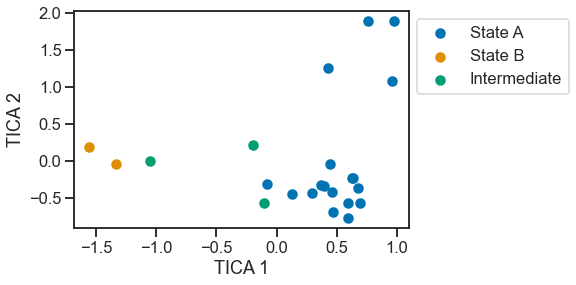

Generate synthetic trajectories from MSMs at different lag times

In [191]:
synth_dtrajs = synthetic_trajectories(dtrajs, lags)
np.save(out_dir.joinpath('synthetic_dtrajs.npy'), synth_dtrajs)

# Mechanism plots

## p(x|TP) (indirect paths only)

/tmp/ipykernel_29508/881290053.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tps_ = np.random.choice(tps, len(tps))
/tmp/ipykernel_29508/881290053.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tps_indir = np.array([path[1:-1] for path in tps if len(path) > 2])


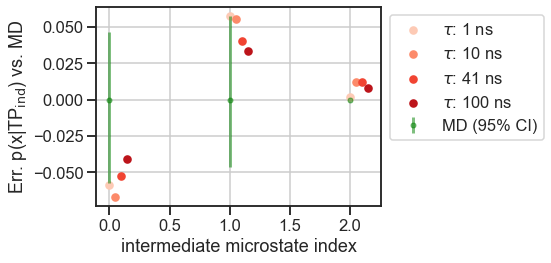

In [204]:
md_stats = get_tps_w_stats(dtrajs, stateA, stateB, n_states=n_states, bootstrap=True)
msm_stats = [get_tps_w_stats(synth_dtraj, stateA, stateB, n_states=n_states) for synth_dtraj in synth_dtrajs]

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(8, 4))
    md_kwargs = dict(color='green',  fmt='o', elinewidth=3, alpha=0.5,  
                ms=5)
    msm_kwargs = dict(s=50)    
    ax = plot_state_prop_given_tp(md_stats, msm_stats, lags, ax,  md_kwargs, msm_kwargs)
    plt.savefig(out_dir.joinpath('p_X_TP.pdf'), bbox_inches='tight')

Text(0.5, 0, 'TICA 1')

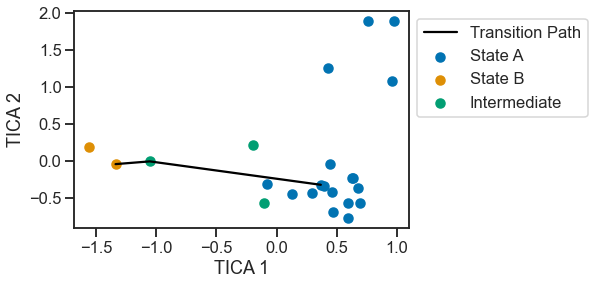

In [206]:

x_ix = 0
y_ix = 1
example_path = md_stats.transition_paths[0]

vals, counts = np.unique(dtrajs_all, return_counts=True)
probs = counts/counts.sum()
F = -np.log(probs)
fig, ax = plt.subplots()

cols = sns.color_palette('colorblind', 3)

ax.scatter(ccs[np.array(stateA), x_ix], ccs[np.array(stateA),y_ix], color=cols[0], label='State A')
    
ax.scatter(ccs[np.array(stateB), x_ix], ccs[np.array(stateB),y_ix], color=cols[1], label='State B')

int_ix = np.array([x for x in range(n_states) if x not in stateA + stateB])

ax.scatter(ccs[int_ix, x_ix], ccs[int_ix,y_ix], color=cols[2], label='Intermediate')

path_ix = np.array(example_path)
ax.plot(ccs[path_ix, x_ix], ccs[path_ix, y_ix], color='k', label='Transition Path')

ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set_ylabel(f"TICA {y_ix+1}")
ax.set_xlabel(f"TICA {x_ix+1}")

In [113]:
len(tps_md), len(pdirect_md), len(mean_length_md), len(counts_md)

(257, 99, 99, 99)

In [116]:
counts_md[0]

array([0.00917874, 0.        , 0.01074879, 0.04758454, 0.05108696,
       0.00917874, 0.0736715 , 0.03152174, 0.09625604, 0.01111111,
       0.01074879, 0.02512077, 0.02041063, 0.00048309, 0.01256039,
       0.        , 0.04299517, 0.02282609, 0.        , 0.0339372 ,
       0.04480676, 0.01376812, 0.0236715 , 0.01086957, 0.06086957,
       0.06328502, 0.0384058 , 0.05603865, 0.00797101, 0.00036232,
       0.00664251, 0.00024155, 0.0910628 , 0.025     , 0.        ,
       0.00157005, 0.03309179, 0.01292271])

In [44]:
len(tps_md), len([path for path in tps_md if len(path) > 2]) # all, and indirect paths only

(257, 107)

# 10 intermediate states: fundamental sequences (indirect paths only)

## new haMSM estimation with coarse macrostates

In [53]:
dtrajs_ = copy.deepcopy(dtrajs) # coarse_macrostates = True modifies dtrajs
nm_model = NonMarkovModel(dtrajs_, stateA, stateB, lag_time=1, coarse_macrostates=True) 


In [54]:
# make micro --> macro dictionary for path coarse-graining
nm_dict = dict()
nm_dict['A'] = nm_model.stateA[0]
nm_dict['B'] = nm_model.stateB[0]

for j in range(len(dtrajs)):
    for i in range(len(dtrajs[j])):
        if len(nm_dict) == nm_model.n_states:
            break
        if dtrajs[j][i] not in stateA+stateB:  
            nm_dict[dtrajs[j][i]] = nm_model.trajectories[j][i]

## MD 

In [55]:
FS_md, FSweights_md = get_fundamental_sequences(tps_md, stateA, stateB, nm_dict, nm_model.markov_tmatrix)

FS_md_bootstrap, FSweights_md_bootstrap = get_fundamental_sequences(tps_md, stateA, stateB, nm_dict, nm_model.markov_tmatrix, bootstrap=True, n_samples=100)

/tmp/ipykernel_29508/1878727487.py:152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tps_coarse_ = np.random.choice(tps_coarse, len(tps_coarse))


## MSMs

In [56]:
lags

array([  1.,   2.,   4.,  10.,  50., 100., 200.])

In [57]:
FS_msms = []
FSweights_msms = []

for i,tps in enumerate(tps_msms):
    print(lags[i])
    nm_model.lag_time = int(lags[i])
    FS, FSweights = get_fundamental_sequences(tps, stateA, stateB, nm_dict, nm_model.markov_tmatrix)
    FS_msms.append(FS)
    FSweights_msms.append(FSweights)       

nm_model.lag_time = 1    

1.0
2.0
4.0
10.0
50.0
100.0
200.0


## haMSMs

In [58]:
# FS_hamsms = []
# FSweights_hamsms = []

# for i,tps in enumerate(tps_hamsms):
#     FS, FSweights = get_fundamental_sequences(tps, stateA, stateB, nm_dict, nm_model.markov_tmatrix)
#     FS_hamsms.append(FS)
#     FSweights_hamsms.append(FSweights)   

## find common fundamental sequences

In [59]:
FS_md_indexdict = dict()
for i,seq in enumerate(FS_md):
    FS_md_indexdict[seq] = i

# MD
FSweights_md_bootstrap_common = []
for i in range(len(FS_md_bootstrap)):
    FS = FS_md_bootstrap[i]
    FSweights = FSweights_md_bootstrap[i]
    FSweights_common = get_common_fundamental_sequences(FS, FSweights, FS_md, FS_md_indexdict)
    FSweights_md_bootstrap_common.append(FSweights_common)            

# MSMs
FSweights_msms_common = []
for i in range(len(FS_msms)):
    FS = FS_msms[i]
    FSweights = FSweights_msms[i]
    FSweights_common = get_common_fundamental_sequences(FS, FSweights, FS_md, FS_md_indexdict) 
    FSweights_msms_common.append(FSweights_common)    

# # haMSMs
# FSweights_hamsms_common = []
# for i in range(len(FS_hamsms)):
#     FS = FS_hamsms[i]
#     FSweights = FSweights_hamsms[i]
#     FSweights_common = get_common_fundamental_sequences(FS, FSweights, FS_md, FS_md_indexdict)
#     FSweights_hamsms_common.append(FSweights_common)     

## plot

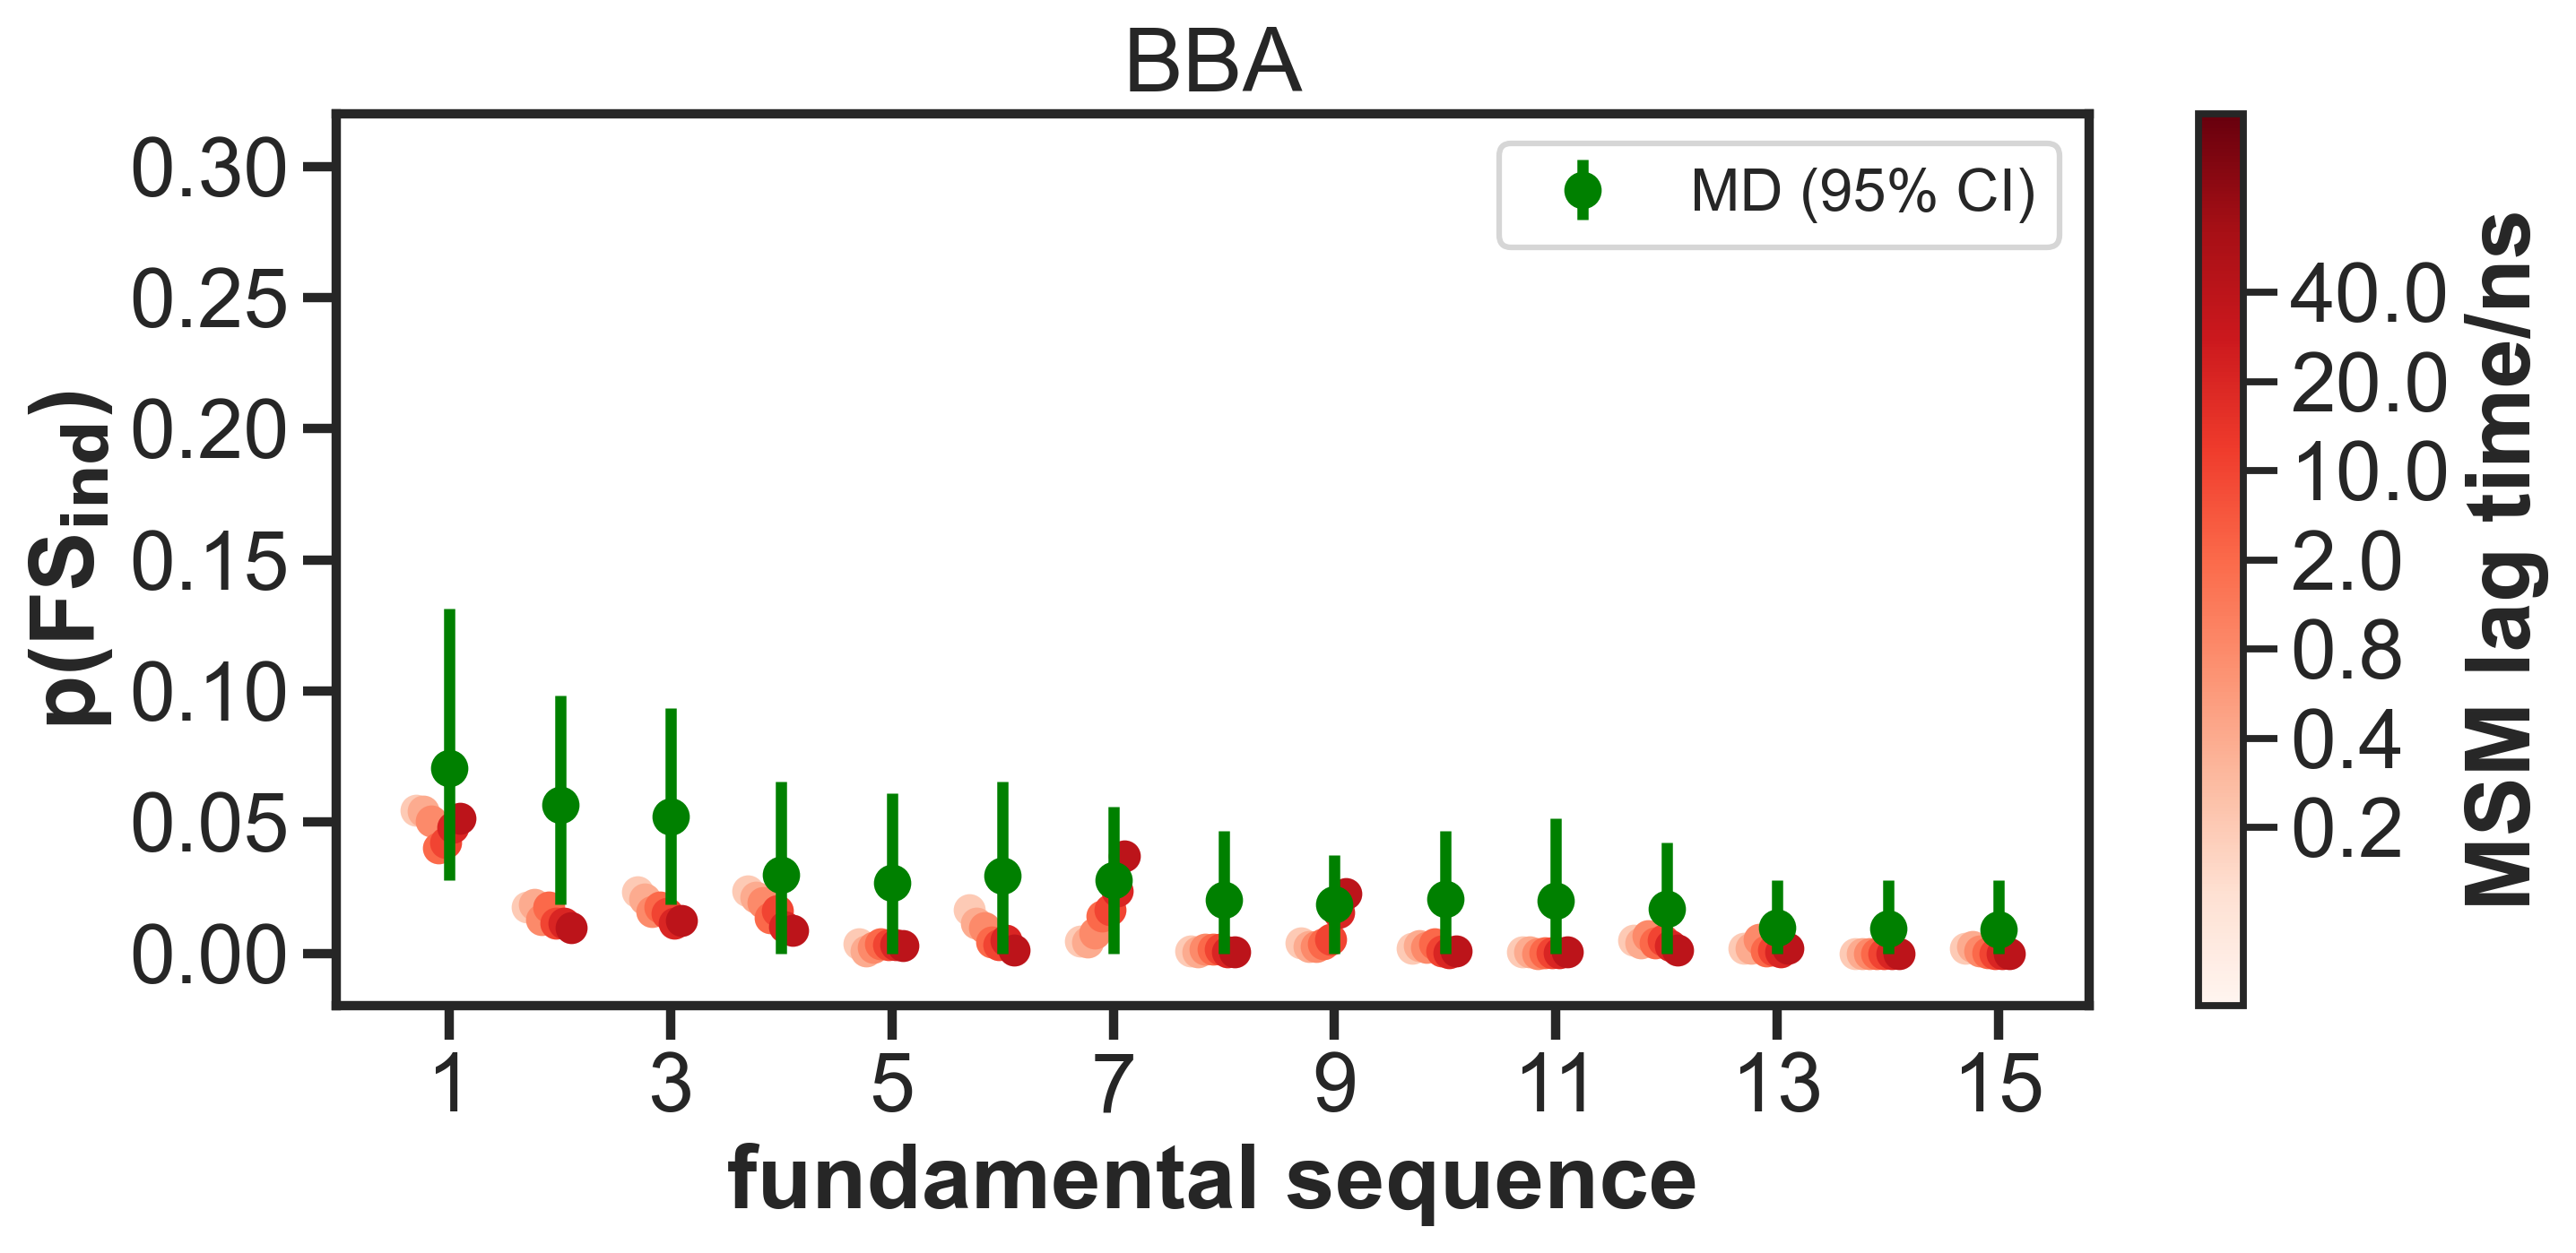

In [72]:
no_paths = 15

fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

ax = fig.add_subplot(111)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
ax.tick_params(width=2.5)

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(len(msms)):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,no_paths+0.5), 
                FSweights_msms_common[msm_index][:no_paths], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(n_lags))
cbar.set_ticklabels(lags[:n_lags]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=24, weight='bold')
cbar.ax.tick_params(labelsize=22)

plt.errorbar(range(1,no_paths+1), np.mean(FSweights_md_bootstrap_common, axis=0)[:no_paths], 
             yerr=[(np.mean(FSweights_md_bootstrap_common, axis=0)-np.percentile(FSweights_md_bootstrap_common, 2.5, axis=0))[:no_paths], 
                   (np.percentile(FSweights_md_bootstrap_common, 97.5, axis=0)-np.mean(FSweights_md_bootstrap_common, axis=0))[:no_paths]], 
             color='green', label='MD (95% CI)', fmt='o', elinewidth=3)

# plt.scatter(np.arange(1,no_paths+1), FSweights_hamsms_common[0][:no_paths], color='blue', label='haMSM (lag=0.2ns, full hist.)', marker='o')
# plt.scatter(np.arange(1,no_paths+1), FSweights_hamsms_common[1][:no_paths], color='blue', label='haMSM (lag=0.2ns, hist.=1ns)', marker='d')
# plt.scatter(np.arange(1,no_paths+1), FSweights_hamsms_common[4][:no_paths], color='blue', label='haMSM (lag=0.2ns, hist.=10ns)', marker='p')

plt.xlabel('fundamental sequence', fontsize=24, weight='bold')
plt.ylabel('p(FS$_\mathbf{ind}$)', fontsize=24, weight='bold')
plt.xticks(np.arange(1,no_paths+1,2), np.arange(1,no_paths+1,2), fontsize=22)
plt.yticks(np.arange(0, 0.35, 0.05), fontsize=22)
plt.ylim(-0.02, 0.32)
plt.title('{}'.format(system_name), fontsize=24)
plt.legend(fontsize=16)

plt.tight_layout()
plt.savefig(out_dir.joinpath(f'{system_name}_pFS_main.pdf'))

plt.show()

# Multiple numbers of intermediate states, stride = 0.2 ns

## choose PCCA cutoffs 

In [73]:
stateAs = []
stateBs = []
intermediate_lens = []

for i in np.arange(0.05, 0.8, 0.1):

    cutoff = 0.5
    intermediate_len = 0
    while intermediate_len < i*msm.nstates:
        
        cutoff += 0.001 # adjust to make possible to get 10% intermediate

        stateA_ = np.concatenate(np.argwhere(pcca.memberships[:,stateA_index] > cutoff)).tolist()
        stateB_ = np.concatenate(np.argwhere(pcca.memberships[:,stateB_index] > cutoff)).tolist()

        intermediate_len = msm.nstates - len(stateA_) - len(stateB_) 
        
    stateAs.append(stateA_)
    stateBs.append(stateB_)
    intermediate_lens.append(intermediate_len)

intermediate_lens = np.array(intermediate_lens)

In [74]:
intermediate_lens

array([ 19,  57,  98, 136, 173, 210, 251, 286])

## MD

In [75]:
tps_md_cutoffs = []
pdirect_md_cutoffs = []
length_md_cutoffs = []
counts_md_cutoffs = []

for i in range(len(intermediate_lens)):
    
    stateA_= stateAs[i] # unfolded
    stateB_ = stateBs[i] # folded
    
    tps, pdirect, mean_length, counts = get_tps_w_stats(dtrajs, stateA_, stateB_, n_states=n_states, bootstrap=True, n_samples=100)

    tps_md_cutoffs.append(tps)
    pdirect_md_cutoffs.append(pdirect)
    length_md_cutoffs.append(mean_length)
    counts_md_cutoffs.append(counts)

/tmp/ipykernel_29508/1878727487.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tps_ = np.random.choice(tps, len(tps))
/tmp/ipykernel_29508/1878727487.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tps_indir = np.array([path[1:-1] for path in tps if len(path) > 2])


In [76]:
# all paths
[len(tps) for tps in tps_md_cutoffs]

[665, 133, 87, 75, 62, 51, 48, 27]

In [77]:
# indirect paths only
[len([path for path in tps if len(path) > 2]) for tps in tps_md_cutoffs]

[125, 86, 74, 67, 61, 51, 48, 27]

## MSMs

In [79]:
tps_msms_cutoffs = []
pdirect_msms_cutoffs = []
length_msms_cutoffs = []
counts_msms_cutoffs = []

for i in range(len(intermediate_lens)):
    
    stateA_= stateAs[i] # unfolded
    stateB_ = stateBs[i] # folded
    
    tps_ = []
    pdirect_ = []
    length_ = []
    counts_ = []

    for dtrajs_msm in dtrajs_msms:
        tps, pdirect, mean_length, counts = get_tps_w_stats(dtrajs_msm, stateA_, stateB_, n_states=n_states)
        tps_.append(tps)
        pdirect_.append(pdirect)
        length_.append(mean_length)
        counts_.append(counts)
        
    tps_msms_cutoffs.append(tps_)
    pdirect_msms_cutoffs.append(pdirect_)
    length_msms_cutoffs.append(length_)
    counts_msms_cutoffs.append(counts_)
    
# multiply mean path lengths by lag times to have all in 0.2 ns steps for comparison
length_msms_cutoffs = [x * lags for x in length_msms_cutoffs]

/tmp/ipykernel_29508/1878727487.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tps_indir = np.array([path[1:-1] for path in tps if len(path) > 2])


In [80]:
# all paths
for i in range(len(intermediate_lens)):
    print([len(tps) for tps in tps_msms_cutoffs[i]])

[3083, 3684, 4612, 6150, 13430, 20808, 33290]
[1985, 2422, 3076, 4136, 8930, 13468, 21080]
[1873, 2288, 2950, 3988, 8576, 12950, 20350]
[1805, 2230, 2860, 3876, 8328, 12607, 19790]
[1713, 2094, 2710, 3646, 8022, 12239, 19254]
[1590, 1932, 2564, 3502, 7850, 11935, 18718]
[1510, 1864, 2507, 3396, 7674, 11521, 18052]
[1142, 1494, 2097, 2974, 6978, 10663, 16728]


In [81]:
# indirect paths only
for i in range(len(intermediate_lens)):
    print([len([path for path in tps if len(path) > 2]) for tps in tps_msms_cutoffs[i]])

[1458, 1731, 2280, 3215, 7523, 10732, 14885]
[1854, 2240, 2851, 3859, 8363, 12450, 18799]
[1843, 2240, 2871, 3910, 8413, 12585, 19396]
[1782, 2205, 2811, 3851, 8234, 12417, 19381]
[1708, 2092, 2710, 3646, 7985, 12183, 19030]
[1590, 1932, 2564, 3502, 7813, 11898, 18554]
[1510, 1864, 2507, 3396, 7649, 11509, 17981]
[1142, 1494, 2097, 2974, 6978, 10663, 16728]


## haMSMs: estimate and simulate

In [82]:
# pool = multiprocessing.Pool(8)

# arguments = []
# for i in range(len(intermediate_lens)):
    
#     stateA_= stateAs[i] # unfolded
#     stateB_ = stateBs[i] # folded
    
#     arguments.append((dtrajs_nm, stateA_, stateB_, 'all'))

# out = pool.starmap(estimate_simulate_hamsm, arguments)
# pool.close()
# pool.join()

# hamsms_cutoffs = [x[0] for x in out]
# dtrajs_hamsms_cutoffs = [x[1] for x in out]
# del out

# np.save('{}_dtrajs_hamsms_cutoffs.npy'.format(system_name), dtrajs_hamsms_cutoffs)
# # OR RELOAD
# # dtrajs_hamsms_cutoffs = np.load('{}_dtrajs_hamsms_cutoffs.npy'.format(system_name), allow_pickle=True)

## haMSMs: count

In [83]:
# tps_hamsms_cutoffs = []
# pdirect_hamsms_cutoffs = []
# length_hamsms_cutoffs = []
# counts_hamsms_cutoffs = []

# for i in range(len(intermediate_lens)):
    
#     stateA_= stateAs[i] # unfolded
#     stateB_ = stateBs[i] # folded
    
#     tps, pdirect, mean_length, counts = get_tps_w_stats(dtrajs_hamsms_cutoffs[i], stateA_, stateB_, n_states=100)

#     tps_hamsms_cutoffs.append(tps)
#     pdirect_hamsms_cutoffs.append(pdirect)
#     length_hamsms_cutoffs.append(mean_length)
#     counts_hamsms_cutoffs.append(counts)

In [84]:
# all paths
# [len(tps) for tps in tps_hamsms_cutoffs]

In [85]:
# # indirect paths only
# [len([path for path in tps if len(path) > 2]) for tps in tps_hamsms_cutoffs]

## plot: p(direct TP)

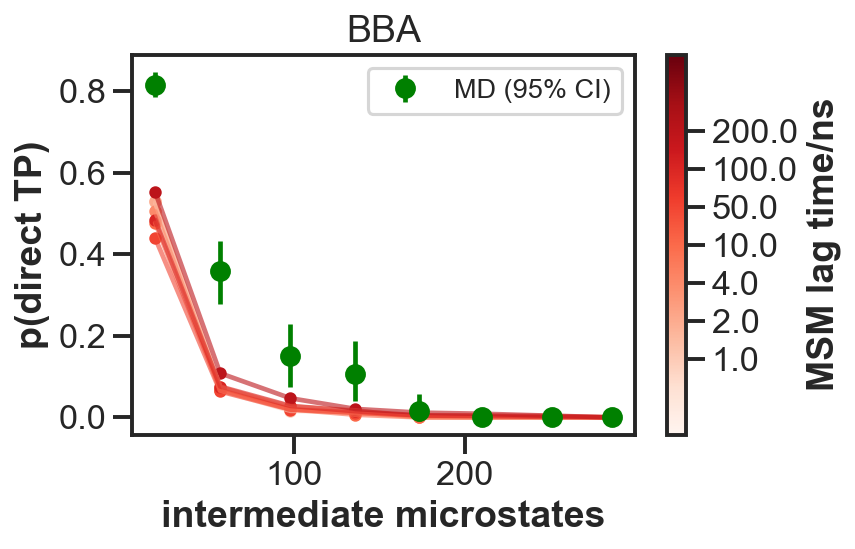

In [88]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(n_lags):
    y = [i[msm_index] for i in pdirect_msms_cutoffs]
    plt.scatter(intermediate_lens,y, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens,y, color=cmap.to_rgba(msm_index), alpha=0.6)
    
cbar = plt.colorbar(cmap)
cbar.set_ticks(range(n_lags))
cbar.set_ticklabels(lags[:n_lags])
cbar.set_label('MSM lag time/ns', weight='bold')    

plt.errorbar(intermediate_lens, np.mean(pdirect_md_cutoffs, axis=1), yerr=[(np.mean(pdirect_md_cutoffs, axis=1)-np.percentile(pdirect_md_cutoffs, 2.5, axis=1)), (np.percentile(pdirect_md_cutoffs, 97.5, axis=1)-np.mean(pdirect_md_cutoffs, axis=1))], color='green', label='MD (95% CI)', fmt='o')

# plt.scatter(intermediate_lens, pdirect_hamsms_cutoffs, s=30, color='blue')
# plt.plot(intermediate_lens, pdirect_hamsms_cutoffs, color='blue', label='haMSM (lag=0.2ns)')

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('p(direct TP)', weight='bold')
# plt.xticks(range(0,100,25))
plt.title('{}'.format(system_name))
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('{}_pdirectTP_vsnomicrostates.pdf'.format(system_name))

plt.show()

## plot: absolute error of p(x|TP) (indirect paths only)

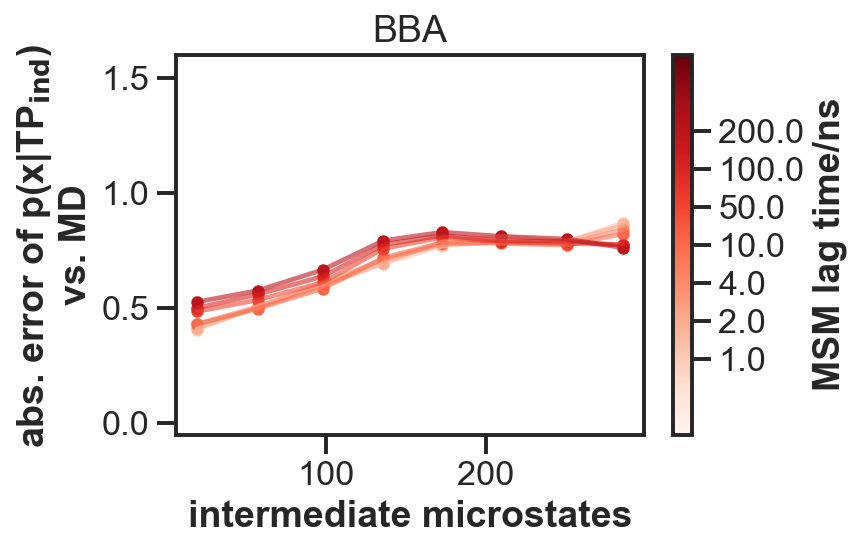

In [91]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(n_lags):
    y = np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_msms_cutoffs[i][msm_index]) for i in range(len(counts_msms_cutoffs))])
    plt.scatter(intermediate_lens, y, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens, y, color=cmap.to_rgba(msm_index), alpha=0.6)
    
cbar = plt.colorbar(cmap)
cbar.set_ticks(range(n_lags))
cbar.set_ticklabels(lags[:n_lags])
cbar.set_label('MSM lag time/ns', weight='bold')    

# plt.scatter(intermediate_lens, np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_hamsms_cutoffs[i]) for i in range(len(counts_hamsms_cutoffs))]), s=30, color='blue')
# plt.plot(intermediate_lens, np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_hamsms_cutoffs[i]) for i in range(len(counts_hamsms_cutoffs))]), color='blue', label='haMSM (lag=0.2ns)')

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('abs. error of p(x|TP$_\mathbf{ind}$) \nvs. MD', weight='bold')
# plt.xticks(range(0,100,25))
plt.ylim(-0.05,1.6)
plt.title('{}'.format(system_name))
# plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('{}_pxTPAE_vsnomicrostates.pdf'.format(system_name))

plt.show()

## plot: mean TP length

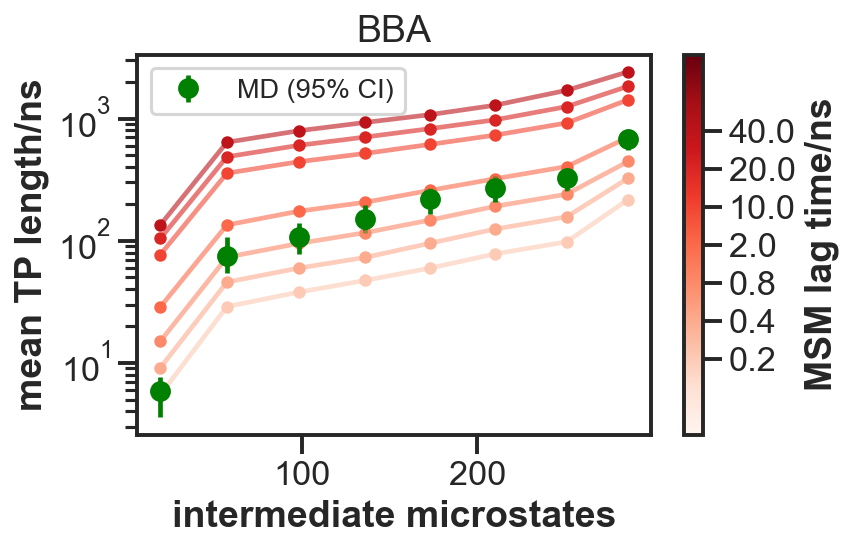

In [92]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(n_lags):
    y = np.array([i[msm_index] for i in length_msms_cutoffs])
    plt.scatter(intermediate_lens, y, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens, y, color=cmap.to_rgba(msm_index), alpha=0.6)

plt.errorbar(intermediate_lens, np.mean(length_md_cutoffs, axis=1), yerr=[(np.mean(length_md_cutoffs, axis=1)-np.percentile(length_md_cutoffs, 2.5, axis=1)), (np.percentile(length_md_cutoffs, 97.5, axis=1)-np.mean(length_md_cutoffs, axis=1))], color='green', label='MD (95% CI)', fmt='o')

# plt.scatter(intermediate_lens, length_hamsms_cutoffs, s=30, color='blue')
# plt.plot(intermediate_lens, length_hamsms_cutoffs, color='blue', label='haMSM (lag=0.2ns)')

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(n_lags))
cbar.set_ticklabels(lags[:n_lags]*0.2)
cbar.set_label('MSM lag time/ns', weight='bold')

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('mean TP length/ns', weight='bold')
plt.yscale('log')
# plt.xticks(range(0,100,25))
plt.title('{}'.format(system_name))
plt.legend(fontsize=13, loc='upper left')

plt.tight_layout()
plt.savefig('{}_TPlength_vsnomicrostates.pdf'.format(system_name))

plt.show()

# Multiple numbers of intermediate states, MSMs trained on stride = lag

## MSMs: estimate and simulate

In [170]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000])

pool = multiprocessing.Pool(8)
out = pool.starmap(estimate_simulate_msm, ([([dtrajs[0][::lag]], 1) for lag in lags]))
pool.close()
pool.join()

msms_strides = [x[0] for x in out]
dtrajs_msms_strides = [x[1] for x in out]
del out

np.save('{}_dtrajs_msms_strides.npy'.format(system_name), dtrajs_msms_strides)
# OR RELOAD
# dtrajs_msms_strides = np.load('{}_dtrajs_msms_strides.npy'.format(system_name), allow_pickle=True)

## MSMs: count

In [211]:
tps_msms_cutoffs_strides = []
pdirect_msms_cutoffs_strides = []
length_msms_cutoffs_strides = []
counts_msms_cutoffs_strides = []

for i in range(len(intermediate_lens)):
    
    stateA_= stateAs[i] # unfolded
    stateB_ = stateBs[i] # folded
    
    tps_ = []
    pdirect_ = []
    length_ = []
    counts_ = []

    for dtrajs_msm in dtrajs_msms_strides:
        tps, pdirect, mean_length, counts = get_tps_w_stats(dtrajs_msm, stateA_, stateB_, n_states=100)
        tps_.append(tps)
        pdirect_.append(pdirect)
        length_.append(mean_length)
        counts_.append(counts)
        
    tps_msms_cutoffs_strides.append(tps_)
    pdirect_msms_cutoffs_strides.append(pdirect_)
    length_msms_cutoffs_strides.append(length_)
    counts_msms_cutoffs_strides.append(counts_)
    
# multiply mean path lengths by lag times to have all in 0.2 ns steps for comparison
length_msms_cutoffs_strides = [x * lags for x in length_msms_cutoffs_strides]

In [212]:
# all paths
for i in range(len(intermediate_lens)):
    print([len(tps) for tps in tps_msms_cutoffs_strides[i]])

[2273, 3463, 4236, 6283, 10469, 357604, 368016, 386686, 312597]
[1875, 3073, 3904, 5907, 10025, 298854, 353272, 382062, 294725]
[1875, 3069, 3880, 5877, 9894, 196034, 314400, 354828, 278817]
[1873, 3045, 3850, 5825, 9738, 174184, 306122, 337816, 267857]
[1839, 3009, 3820, 5767, 9588, 169882, 247174, 328002, 178495]
[1837, 2985, 3766, 5685, 9396, 97994, 178299, 283933, 140799]
[1771, 2899, 3644, 5511, 8922, 87944, 122719, 265645, 81808]
[1241, 2035, 2616, 3927, 5352, 18050, 41366, 57944, 34712]


In [213]:
# indirect paths only
for i in range(len(intermediate_lens)):
    print([len([path for path in tps if len(path) > 2]) for tps in tps_msms_cutoffs_strides[i]])

[1439, 2161, 2469, 3345, 3778, 3794, 3329, 24587, 38348]
[1526, 2430, 2909, 4126, 5942, 30367, 35068, 26773, 68459]
[1535, 2505, 3085, 4327, 6757, 39881, 90805, 68942, 72176]
[1564, 2640, 3328, 4603, 7252, 40678, 95359, 86144, 90601]
[1597, 2678, 3386, 4784, 7428, 44962, 118139, 95082, 102608]
[1632, 2680, 3486, 4992, 7880, 38369, 108103, 112644, 92324]
[1619, 2734, 3455, 5130, 7838, 35671, 82523, 111254, 42718]
[1238, 2024, 2588, 3808, 5189, 16222, 30235, 31900, 15088]


## plot: p(direct TP)

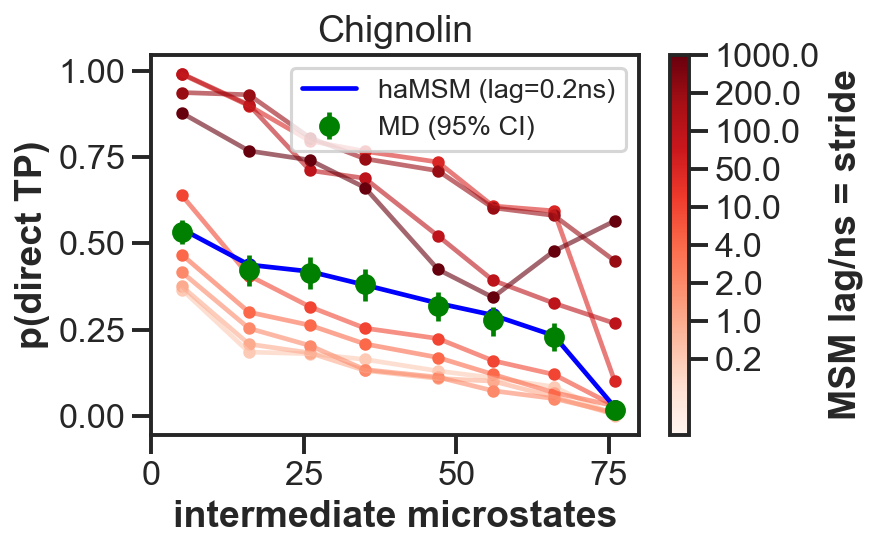

In [214]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    y = [i[msm_index] for i in pdirect_msms_cutoffs_strides]
    plt.scatter(intermediate_lens,y, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens,y, color=cmap.to_rgba(msm_index), alpha=0.6)
    
cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag/ns = stride', weight='bold')    

plt.errorbar(intermediate_lens, np.mean(pdirect_md_cutoffs, axis=1), yerr=[(np.mean(pdirect_md_cutoffs, axis=1)-np.percentile(pdirect_md_cutoffs, 2.5, axis=1)), (np.percentile(pdirect_md_cutoffs, 97.5, axis=1)-np.mean(pdirect_md_cutoffs, axis=1))], color='green', label='MD (95% CI)', fmt='o')

plt.scatter(intermediate_lens, pdirect_hamsms_cutoffs, s=30, color='blue')
plt.plot(intermediate_lens, pdirect_hamsms_cutoffs, color='blue', label='haMSM (lag=0.2ns)')

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('p(direct TP)', weight='bold')
plt.xticks(range(0,100,25))
plt.title('{}'.format(system_name))
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('{}_pdirectTP_vsnomicrostates_strideeqlag.pdf'.format(system_name))

plt.show()

## plot: absolute error of p(x|TP) (indirect paths only)

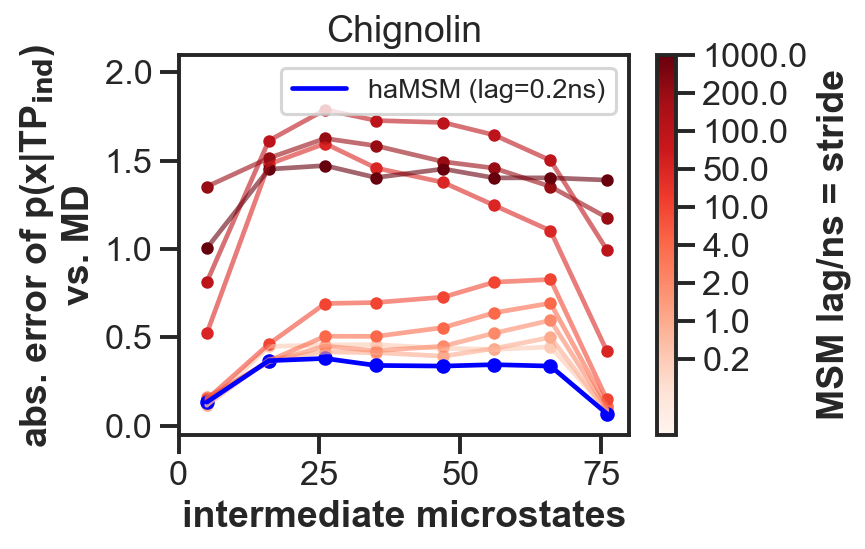

In [215]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    y = np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_msms_cutoffs_strides[i][msm_index]) for i in range(len(counts_msms_cutoffs_strides))])
    plt.scatter(intermediate_lens, y, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens, y, color=cmap.to_rgba(msm_index), alpha=0.6)
    
cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag/ns = stride', weight='bold')  

plt.scatter(intermediate_lens, np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_hamsms_cutoffs[i]) for i in range(len(counts_hamsms_cutoffs))]), s=30, color='blue')
plt.plot(intermediate_lens, np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_hamsms_cutoffs[i]) for i in range(len(counts_hamsms_cutoffs))]), color='blue', label='haMSM (lag=0.2ns)')

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('abs. error of p(x|TP$_\mathbf{ind}$) \nvs. MD', weight='bold')
plt.xticks(range(0,100,25))
plt.ylim(-0.05,2.1)
plt.title('{}'.format(system_name))
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('{}_pxTPAE_vsnomicrostates_strideeqlag.pdf'.format(system_name))

plt.show()

## plot: mean TP length

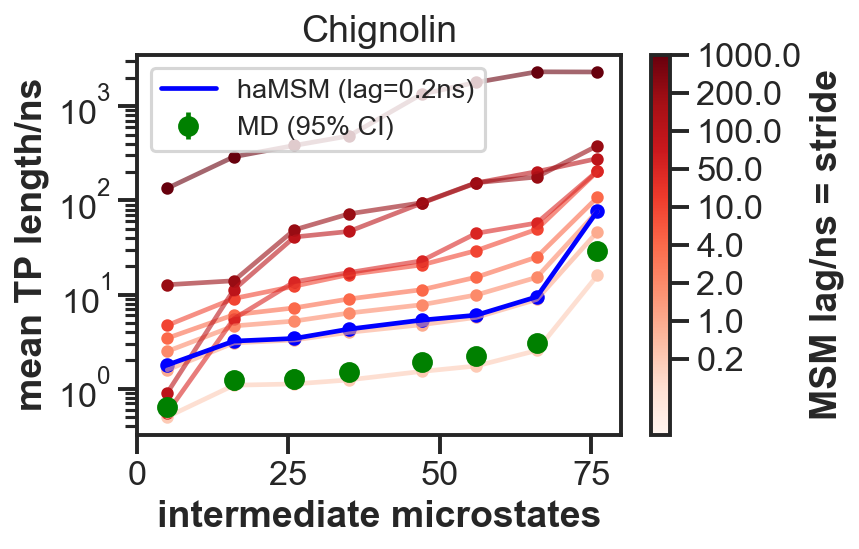

In [217]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    y = np.array([i[msm_index] for i in length_msms_cutoffs_strides])
    plt.scatter(intermediate_lens, y*0.2, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens, y*0.2, color=cmap.to_rgba(msm_index), alpha=0.6)

plt.errorbar(intermediate_lens, np.mean(length_md_cutoffs, axis=1)*0.2, yerr=[(np.mean(length_md_cutoffs, axis=1)-np.percentile(length_md_cutoffs, 2.5, axis=1))*0.2, (np.percentile(length_md_cutoffs, 97.5, axis=1)-np.mean(length_md_cutoffs, axis=1))*0.2], color='green', label='MD (95% CI)', fmt='o')

plt.scatter(intermediate_lens, length_hamsms_cutoffs, s=30, color='blue')
plt.plot(intermediate_lens, length_hamsms_cutoffs, color='blue', label='haMSM (lag=0.2ns)')

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag/ns = stride', weight='bold') 

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('mean TP length/ns', weight='bold')
plt.yscale('log')
plt.xticks(range(0,100,25))
plt.title('{}'.format(system_name))
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('{}_TPlength_vsnomicrostates_strideeqlag.pdf'.format(system_name))

plt.show()